# 2016 US Bike Share Activity Snapshot

## Table of Contents
- [Introduction](#intro)
- [Posing Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Performing Your Own Analysis](#eda_continued)
- [Conclusions](#conclusions)

<a id='intro'></a>
## Introduction

Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, we will perform an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. We will compare the system usage between three large cities: New York City, Chicago, and Washington, DC. We will also see if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='pose_questions'></a>
## Posing Questions

What days are subscribers and customers more actively using the service?

Does day of the week have an effect on duration of trips?


<a id='wrangling'></a>
## Data Collection and Wrangling

Now it's time to collect and explore our data. In this project, we will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)


In [34]:
## import all necessary packages and functions.
import csv # read and write csv files
from datetime import datetime # operations to parse dates
from pprint import pprint # use to print data structures like dictionaries in
                          # a nicer way than the base print function.

In [35]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        trip_reader = csv.DictReader(f_in)
        ## TODO: Use the csv library to set up a DictReader object. ##
        ## see https://docs.python.org/3/library/csv.html           ##
        
        ## TODO: Use a function on the DictReader object to read the     ##
        ## first trip from the data file and store it in a variable.     ##
        ## see https://docs.python.org/3/library/csv.html#reader-objects ##
        first_trip = next(trip_reader)
        
        ## TODO: Use the pprint library to print the first trip. ##
        ## see https://docs.python.org/3/library/pprint.html     ##
        
    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv',]

# print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip
    print(example_trips[city])



City: NYC
OrderedDict([('tripduration', '839'), ('starttime', '1/1/2016 00:09:55'), ('stoptime', '1/1/2016 00:23:54'), ('start station id', '532'), ('start station name', 'S 5 Pl & S 4 St'), ('start station latitude', '40.710451'), ('start station longitude', '-73.960876'), ('end station id', '401'), ('end station name', 'Allen St & Rivington St'), ('end station latitude', '40.72019576'), ('end station longitude', '-73.98997825'), ('bikeid', '17109'), ('usertype', 'Customer'), ('birth year', ''), ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'), ('starttime', '3/31/2016 23:30'), ('stoptime', '3/31/2016 23:46'), ('bikeid', '2295'), ('tripduration', '926'), ('from_station_id', '156'), ('from_station_name', 'Clark St & Wellington Ave'), ('to_station_id', '166'), ('to_station_name', 'Ashland Ave & Wrightwood Ave'), ('usertype', 'Subscriber'), ('gender', 'Male'), ('birthyear', '1990')])

City: Washington
OrderedDict([('Duration (ms)', '427387'), ('Start date', '3/31/201



<a id='condensing'></a>
### Condensing the Trip Data

It should also be observable from the above printout that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make things as simple as possible when we get to the actual exploration, we should trim and clean the data. Cleaning the data makes sure that the data formats across the cities are consistent, while trimming focuses only on the parts of the data we are most interested in to make the exploration easier to work with.

We will generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. Use the start time of the trip to obtain these values. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. The [`datetime`](https://docs.python.org/3/library/datetime.html) package will be very useful here to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, we will convert the Washington labels to match the other two. It also turns out that there are some trips in the New York city dataset that do not have an attached user type. Since we don't have enough information to fill these values in, we will 
just leave them as-is for now.

In [36]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    
    Remember that Washington is in terms of milliseconds while Chicago and NYC
    are in terms of seconds. 
    """
    
    mill_to_min = 60000.0
    sec_to_min = 60.0
    if city == "Washington":
        duration = float(datum["Duration (ms)"])/mill_to_min
    elif city == "Chicago" or city == "NYC":
        duration = float(datum["tripduration"])/sec_to_min
    return duration

tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [37]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    """
    if city == "Washington":
        time_date = datetime.strptime(datum["Start date"], "%m/%d/%Y %H:%M")
    elif city == "Chicago":
        time_date = datetime.strptime(datum["starttime"], "%m/%d/%Y %H:%M")
    elif city == "NYC":
        time_date = datetime.strptime(datum["starttime"], "%m/%d/%Y %H:%M:%S")
    
    month = int(time_date.strftime("%m"))
    hour = int(time_date.strftime("%H"))
    day_of_week = time_date.strftime("%A")
    
    return (month, hour, day_of_week)

tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    assert time_of_trip(example_trips[city], city) == tests[city]



In [38]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    """
    
    if city == "Washington":
        if datum["Member Type"] == "Registered":
            user_type = "Subscriber"
        else:
            user_type = "Customer"
    elif city == "Chicago":
        if datum["usertype"] == "Subscriber":
            user_type = "Subscriber"
        else:
            user_type = "Customer" 
    elif city == "NYC":
        if datum["usertype"] == "Subscriber":
            user_type = "Subscriber"
        elif datum["usertype"] == "Customer":
            user_type = "Customer"
        else:
            user_type = ""    
    
    return user_type

tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]

In [39]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    """
    
    with open(out_file, 'w', newline='') as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        #set up csv DictReader object
        trip_reader = csv.DictReader(f_in)

        # collect data from and process each row
        for row in trip_reader:
            new_point = {}
            new_point["duration"] = duration_in_mins(row, city)
            month, hour, day_of_week = time_of_trip(row, city)
            new_point["month"] = month
            new_point["hour"] = hour
            new_point["day_of_week"] = day_of_week
            new_point["user_type"] = type_of_user(row, city)
            
            trip_writer.writerow(new_point)
                     

In [40]:
# Check
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington

City: Chicago

City: NYC



<a id='eda'></a>
## Exploratory Data Analysis

Now that we have the data collected and wrangled, we're ready to start exploring the data. In this section we will write some code to compute descriptive statistics from the data.

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts.

In [41]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0
        n_customers = 0
        
        # tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            elif row['user_type'] == 'Customer':
                n_customers += 1
        
        # compute total number of rides
        n_total = n_subscribers + n_customers
        
        # return tallies as a tuple
        return(n_subscribers, n_customers, n_total)

    
def con_data(city_count, city):
    """
    Function takes in number of trips function and city. Outputs a string formatted to present
    the count data. 
    """
    print("\n{} had a total number of {} trips recorded. These consisted of {} by subscribers and {} by customers." \
          .format(city, city_count[2], city_count[0], city_count[1]))
    
con_data(number_of_trips("./data/NYC-2016-Summary.csv"), "NYC")
con_data(number_of_trips("./data/Chicago-2016-Summary.csv"), "Chicago")
con_data(number_of_trips("./data/Washington-2016-Summary.csv"), "Washington")
con_data(number_of_trips("./data/BayArea-Y3-Summary.csv"), "Bay Area")



NYC had a total number of 276081 trips recorded. These consisted of 245896 by subscribers and 30185 by customers.

Chicago had a total number of 72131 trips recorded. These consisted of 54982 by subscribers and 17149 by customers.

Washington had a total number of 66326 trips recorded. These consisted of 51753 by subscribers and 14573 by customers.

Bay Area had a total number of 6299 trips recorded. These consisted of 5666 by subscribers and 633 by customers.


In [42]:
def proportions(city_count):
    '''
    Function takes in a tuple (subscriber count, customer count, total count) and performs calculation to find
    the proportions each make up of the total. It then returns these proportions as a tuple
    '''
    subscriber_prop = format((city_count[0]/city_count[2])*100, '.2f')
    customer_prop = format((city_count[1]/city_count[2])*100, '.2f')
    return(subscriber_prop, customer_prop)

def prop_data(city_props, city):
    """
    Function takes in prop data tuple and a city string and outputs a formatted sentence displaying proportion data
    """
    print("\n Total trips in {} were comprised of {}% subscribers and {}% customers." \
          .format(city, city_props[0], city_props[1]))
    
prop_data(proportions(number_of_trips("./data/NYC-2016-Summary.csv")), "NYC")
prop_data(proportions(number_of_trips("./data/Chicago-2016-Summary.csv")), "Chicago")
prop_data(proportions(number_of_trips("./data/Washington-2016-Summary.csv")), "Washington")
prop_data(proportions(number_of_trips("./data/BayArea-Y3-Summary.csv")), "Bay Area")


 Total trips in NYC were comprised of 89.07% subscribers and 10.93% customers.

 Total trips in Chicago were comprised of 76.23% subscribers and 23.77% customers.

 Total trips in Washington were comprised of 78.03% subscribers and 21.97% customers.

 Total trips in Bay Area were comprised of 89.95% subscribers and 10.05% customers.


In [43]:
def trip_length(filename):
    '''
    Function takes in a filename for a csv data file. It then creates a list of durations from the read data
    '''
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        durations = []
        for row in reader:
            row["duration"] = float(row["duration"])
            durations.append(row["duration"])
    return durations


In [44]:
def avg_duration(city_duration):
    '''
    Simple function that returns the mean of a list of values.
    '''
    average = format(sum(city_duration)/len(city_duration), '.2f')
    return average

print("\nAverage trip duration for NYC was {} minutes".format(avg_duration(trip_length("./data/NYC-2016-Summary.csv"))))
print("\nAverage trip duration for Chicago was {} minutes".format(avg_duration(trip_length("./data/Chicago-2016-Summary.csv"))))
print("\nAverage trip duration for Washington was {} minutes".format(avg_duration(trip_length("./data/Washington-2016-Summary.csv"))))
print("\nAverage trip duration for the Bay Area was {} minutes".format(avg_duration(trip_length('./data/BayArea-Y3-Summary.csv'))))


Average trip duration for NYC was 15.81 minutes

Average trip duration for Chicago was 16.56 minutes

Average trip duration for Washington was 18.93 minutes

Average trip duration for the Bay Area was 14.04 minutes


In [45]:
def under_thirty_dur(durations):
    '''
    Function that takes in a list of durations and performs a tally of those under and over 30 minutes. 
    Returns the over 30 count.
    '''
    under_tally = 0
    over_tally = 0
    for item in durations:
        if item <= 30.0:
            under_tally += 1
        else:
            over_tally += 1
    over_prop = format((over_tally/(over_tally + under_tally))* 100, '.2f')
    return over_prop

print("\nIn NYC, {}% of trips were over 30 minutes long".format(under_thirty_dur(trip_length("./data/NYC-2016-Summary.csv"))))
print("\nIn Chicago, {}% of trips were over 30 minutes long".format(under_thirty_dur(trip_length("./data/Chicago-2016-Summary.csv"))))
print("\nIn Washington, {}% of trips were over 30 minutes long".format(under_thirty_dur(trip_length("./data/Washington-2016-Summary.csv"))))
print("\nIn the Bay Area, {}% of trips were over 30 minutes long".format(under_thirty_dur(trip_length('./data/BayArea-Y3-Summary.csv'))))


In NYC, 7.30% of trips were over 30 minutes long

In Chicago, 8.33% of trips were over 30 minutes long

In Washington, 10.84% of trips were over 30 minutes long

In the Bay Area, 3.52% of trips were over 30 minutes long


In [46]:
def longer_users(filename):
    '''
    Function that takes in data from a csv file and divides durations based on user type. Returns a tuple of lists
    containing the durations for each. 
    '''
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
        subscriber_duration = []
        customer_duration = []
        for row in reader:
            row["duration"] = float(row["duration"])
            if row["user_type"] == "Subscriber":
                subscriber_duration.append(row["duration"])
            else:
                customer_duration.append(row["duration"])
        return subscriber_duration, customer_duration
        
    

def avg_users(user_data):
    '''
    Simple function that passes both the values from the input tuple through the av_duration function
    returns the average for both in tuple form. 
    '''
    sub_average = float(avg_duration(user_data[0]))
    cus_average = float(avg_duration(user_data[1]))
    return sub_average, cus_average

def user_form(longest_users, city):
    '''
    Function used to format the average data into a readable print statement
    '''
    sub_avg, cus_avg = longest_users
    
    print("\nIn {}, the average trip time of subscribers was {} minutes and the average trip time of customers was {} minutes." \
         .format(city, sub_avg, cus_avg))
    
print(user_form(avg_users(longer_users("./data/NYC-2016-Summary.csv")), "NYC"))
print(user_form(avg_users(longer_users("./data/Chicago-2016-Summary.csv")), "Chicago"))
print(user_form(avg_users(longer_users("./data/Washington-2016-Summary.csv")), "Washington"))
print(user_form(avg_users(longer_users("./data/BayArea-Y3-Summary.csv")), "The Bay Area"))


In NYC, the average trip time of subscribers was 13.68 minutes and the average trip time of customers was 32.78 minutes.
None

In Chicago, the average trip time of subscribers was 12.07 minutes and the average trip time of customers was 30.98 minutes.
None

In Washington, the average trip time of subscribers was 12.53 minutes and the average trip time of customers was 41.68 minutes.
None

In The Bay Area, the average trip time of subscribers was 9.51 minutes and the average trip time of customers was 54.55 minutes.
None


<a id='visualizations'></a>
### Visualizations

While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting for us to look at how the trip times are distributed.

In [47]:
# load library
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline 

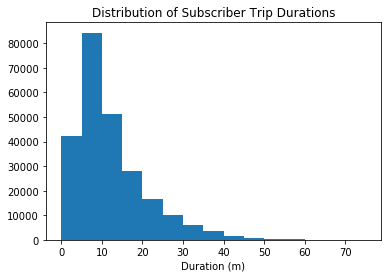

In [48]:
## Use this and additional cells to answer Question 5. ##
plt.hist(longer_users("./data/NYC-2016-Summary.csv")[0], bins = 15, range = (0, 75))
plt.title('Distribution of Subscriber Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

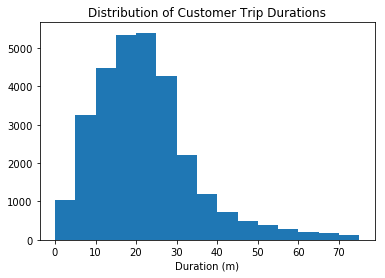

In [49]:
plt.hist(longer_users("./data/NYC-2016-Summary.csv")[1], bins = 15, range = (0, 75))
plt.title('Distribution of Customer Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

In [50]:
def read_in_city(filename):
    '''
    Function to read in data from a csv file and return an ordered dict from this data
    '''
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
        return list(reader)
    
NYC_data = read_in_city("./data/NYC-2016-Summary.csv")
Chicago_data = read_in_city("./data/Chicago-2016-Summary.csv")
Washington_data = read_in_city("./data/Washington-2016-Summary.csv")
Bay_area_data = read_in_city("./data/BayArea-Y3-Summary.csv")

### Durations for all NYC users sorted by day of week

In [51]:
from collections import OrderedDict

def dur_per_day(city_data):
    '''
    Function to sort an input ordered dict into a dictionary of lists for each day of the week. Returns dictionary.
    '''
    day_sorted = OrderedDict([("Monday", []), ("Tuesday", []), ("Wednesday", []), ("Thursday", []), ("Friday", []), ("Saturday", []), ("Sunday", [])])
    for trip in city_data:
            day_sorted[trip["day_of_week"]].append(float(trip["duration"]))
    return day_sorted

def avg_per_day(day_data):
    '''
    Function that will find the averages of list items in a dictionary and return a list of these averages for use
    in visualisations.
    '''
    day_averages = []
    for day in day_data:
        day_averages.append(sum(day_data[day])/len(day_data[day]))
    return day_averages

print(avg_per_day(dur_per_day(NYC_data)))

[15.07595238095228, 14.297031403529449, 14.636322047696872, 14.552951725693545, 16.023964096740567, 18.795957884848054, 18.789433954239893]


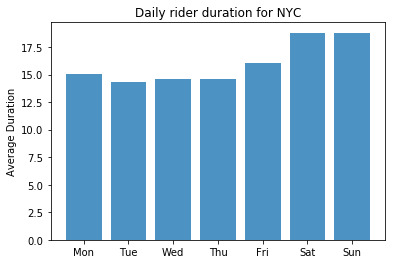

In [52]:
objects = ("Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun")
y_pos = np.arange(len(objects))
performance = avg_per_day(dur_per_day(NYC_data))
 
plt.bar(y_pos, performance, align='center', alpha=0.8)
plt.xticks(y_pos, objects)
plt.ylabel('Average Duration')
plt.title('Daily rider duration for NYC')
 
plt.show()

As we can see from the above diagram, users will on average travel for longer durations on the weekends compared with through the week. This could be because through the week most trips are work related and weekends trips are leisure related. To explore this pattern in more detail, the following section will split user data into their two groups (subscribers and customers) and explore which group is more active on which days. 

### Sorting trip data by type of user

In [53]:
def dur_per_day(city_data):
    '''
    Function to sort ordered dict into two dictionaries of day of the week counts. Returns a tuple of dictionaries.
    '''
    sub_sorted = OrderedDict([("Monday", 0), ("Tuesday", 0), ("Wednesday", 0), ("Thursday", 0), ("Friday", 0), ("Saturday", 0), ("Sunday", 0)])
    cus_sorted = OrderedDict([("Monday", 0), ("Tuesday", 0), ("Wednesday", 0), ("Thursday", 0), ("Friday", 0), ("Saturday", 0), ("Sunday", 0)])
    for trip in city_data:
            if trip["user_type"] == "Subscriber":
                sub_sorted[trip["day_of_week"]] += 1
                #sub_sorted[trip["day_of_week"]].append(float(trip["duration"]))
            else:
                cus_sorted[trip["day_of_week"]] += 1
    return sub_sorted, cus_sorted

def format_daily_dur(day_data):
    '''
    Function to convert dictionary of values into list of values to be used for visualisation.
    '''
    formed_list = []
    for day in day_data:
        formed_list.append(day_data[day])
    return formed_list

print(dur_per_day(NYC_data)[0])
print(dur_per_day(NYC_data)[1])

OrderedDict([('Monday', 35623), ('Tuesday', 39487), ('Wednesday', 41403), ('Thursday', 41197), ('Friday', 37606), ('Saturday', 26126), ('Sunday', 24454)])
OrderedDict([('Monday', 3717), ('Tuesday', 2918), ('Wednesday', 3226), ('Thursday', 3133), ('Friday', 3783), ('Saturday', 7227), ('Sunday', 6898)])


### Trip frequency for subscribers sorted by day of the week

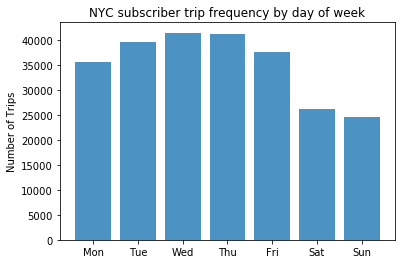

In [54]:
objects = ("Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun")
y_pos = np.arange(len(objects))
performance = format_daily_dur(dur_per_day(NYC_data)[0])
 
plt.bar(y_pos, performance, align='center', alpha=0.8)
plt.xticks(y_pos, objects)
plt.ylabel('Number of Trips')
plt.title('NYC subscriber trip frequency by day of week')
 
plt.show()

As we can see from the above diagram, subscribers highest frequency is on weekdays, particularly Wednesday and Thursday. This could be attributed to subscribers using the service to get to and from work, however we would need to analyse much more data to test this theory. 

### Trip frequency for customers sorted by day of the week

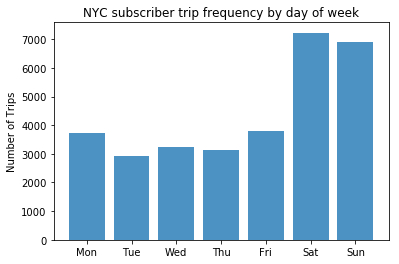

In [55]:
objects = ("Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun")
y_pos = np.arange(len(objects))
performance = customer_daily_data = format_daily_dur(dur_per_day(NYC_data)[1])
 
plt.bar(y_pos, performance, align='center', alpha=0.8)
plt.xticks(y_pos, objects)
plt.ylabel('Number of Trips')
plt.title('NYC subscriber trip frequency by day of week')
 
plt.show()

As we can see from the above diagram, customers highest frequency is on weekends. Weekend frequency is almost double that for any of the weekdays. This could be attributed to customers using the service for leisure activities which are primarily performed on the weekends.